# Import Libraries

In [34]:
import os
import time
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from contextlib import nullcontext

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils import normalize

from datasets import load_dataset, load_from_disk
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
!rm -rf /content/drive

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct  3 10:34:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Data Loading

In [ ]:
def transform(example):
    example["image"] = example["image"].convert("RGB")
    example["image"] = np.array(example["image"], dtype=np.uint8)
    return example

ds = load_dataset("zh-plus/tiny-imagenet")
ds = ds.map(transform, num_proc=4)

save_path = "/content/drive/MyDrive/tiny-imagenet-processed"
os.makedirs(save_path, exist_ok=True)  # создаём папку на всякий случай
ds.save_to_disk(save_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-1359597a978bc4(…):   0%|          | 0.00/146M [00:00<?, ?B/s]

data/valid-00000-of-00001-70d52db3c749a9(…):   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible 

Map (num_proc=4):   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible 

Saving the dataset (0/2 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
PREPROCESS_PATH = "/content/drive/MyDrive/tiny-imagenet-processed"
ds = load_from_disk(PREPROCESS_PATH)

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

# Variables

In [5]:
BATCH_SIZE = 32
IMG_SIZE = 224  # to fit pre-trained models
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 200
EPOCHS = 15

models = {}
histories = {}
train_times = {}
final_table = []

In [6]:
# == Check the number of classes we will classify ==
classes = ds['train'].features['label'] # pyright: ignore[reportOptionalSubscript]
print("Number of classes:", classes.num_classes)

Number of classes: 200


# Data Preprocessing

## Normalization


  == Normalization using ImageNet’s mean and standard deviation ==
    # mean = tf.constant([0.485, 0.456, 0.406])
    # std = tf.constant([0.229, 0.224, 0.225])
    # image = (image - mean) / std

In [7]:
# === Normalization ===
def normalization(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.cast(image, tf.float32)
  return image, label

## Label Encoding

In [8]:
def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=NUM_CLASSES)

## Augmentation

In [9]:
# === Data augmentation ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1)
])

# TF DataSet Pipeline

In [10]:
# == Dataset pipelines ===
tf_train = (ds["train"]
    .to_tf_dataset(columns=["image"], label_cols=["label"], shuffle=True, batch_size=BATCH_SIZE)
    .map(normalization, num_parallel_calls=AUTOTUNE)
    .map(one_hot_encode, num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

tf_valid = (ds["valid"]
    .to_tf_dataset(columns=["image"], label_cols=["label"], shuffle=False, batch_size=BATCH_SIZE)
    .map(normalization, num_parallel_calls=AUTOTUNE)
    .map(one_hot_encode, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

/usr/local/lib/python3.12/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [11]:
for image, label in tf_train.take(1):
    print('Train Set shape:')
    print(image.shape)
    print(label.shape)

for image, label in tf_valid.take(1):
    print('\nVal Set shape:')
    print(image.shape)
    print(label.shape)

Train Set shape:
(32, 224, 224, 3)
(32, 200)

Val Set shape:
(32, 224, 224, 3)
(32, 200)


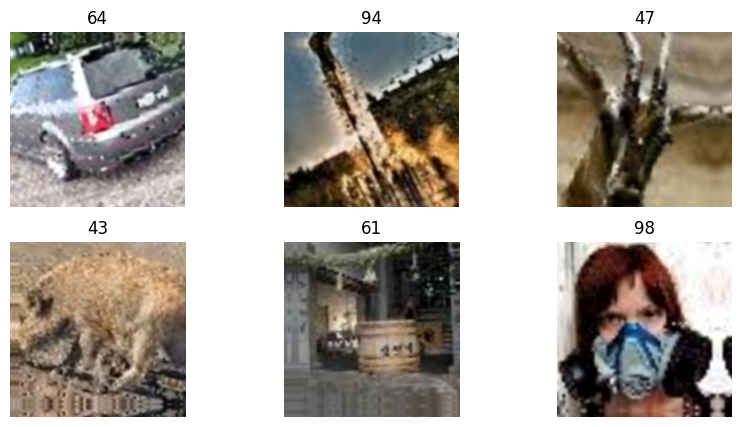

In [12]:
def visualize_sample(data):
    plt.figure(figsize=(10, 5))
    for image_batch, label_batch in data.take(1):
        for i in range(6):
            plt.subplot(2, 3, i+1)
            plt.imshow(image_batch[i] / 255.0)
            plt.title(np.argmax(label_batch[i].numpy(), axis=-1))
            plt.axis('off')
    plt.show()

visualize_sample(tf_train)

# Functions for CNN

##  Model efficiency

In [13]:
# == Computational metrics ==
def measure_latency_ms(model, img_size=IMG_SIZE, device=None, repeats=50, warmup=10):
    context = tf.device(device) if device else nullcontext()
    with context:
        x = tf.random.uniform([1, img_size, img_size, 3])
        for _ in range(warmup):
            _ = model(x, training=False).numpy()
        times = []
        for _ in range(repeats):
            t0 = time.perf_counter()
            _ = model(x, training=False).numpy()
            times.append((time.perf_counter() - t0) * 1000.0)
    return float(np.median(times))

def estimate_memory_usage(model, batch_size=1):
    param_mem = model.count_params() * 4 / (1024**2)  # MB
    input_mem = np.prod(model.input_shape[1:]) * batch_size * 4 / (1024**2)
    return param_mem + input_mem

def efficiency_ratio(acc, params_m, latency_ms):
    # ER = Validation Accuracy (%) / (Inference Time (ms) + Param)
    return (acc * 100) / (latency_ms + params_m)

def get_flops(model, batch_size=1):
  try:
    flops = get_flops(model, batch_size=1) / 10**9
  except:
    flops = None
  return flops

## Training

In [14]:
# == Train & Evaluate Models ==
def train_and_evaluate(model, name, train_set, valid_set, epochs, mode):
    print(f"\n=== Training {name} ===\n")
    # == callbacks =
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor =0.2,
        patience=3,
        min_lr=1e-5,
        verbose=1
    )
    # checkpoint_dir = r"D:/7 semester/ОМСС/checkpoints"
    checkpoint_dir = "/content/drive/MyDrive/checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{name}.h5")

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1
    )

    start = time.time()
    history = model.fit(
            train_set,
            validation_data=tf_valid,
            epochs=epochs,
            callbacks=[early_stopping, reduce_lr, checkpoint]
    )
    end = time.time()
    train_time = (end - start) / 60
    print(f'Training time of {name}: {train_time:.2f} minutes\n')
    training_plot(history)

    # == Metrics ==
    val_metrics = evaluate(model, valid_set)

    total_params_m = model.count_params() / 1e6              # total parameters
    flops = get_flops(model)                                 # flops (training complexity)
    mem_mb = estimate_memory_usage(model)                     #memory
    try:
        lat_gpu = measure_latency_ms(model, device='/GPU:0')  # Latency
    except Exception:
        lat_gpu = None
    lat_cpu = measure_latency_ms(model, device='/CPU:0')

    er_cpu = efficiency_ratio(val_metrics.get('top1_acc', 0), total_params_m, lat_cpu) # ER
    er_gpu = None if lat_gpu is None else efficiency_ratio(val_metrics.get('top1_acc', 0), total_params_m, lat_gpu)

    # Table
    row = {
      'Name': name,
      'Mode' : mode,
      'Loss': val_metrics.get('loss'),
      'Top1 Acc': val_metrics.get('top1_acc'),
      'Top5 Acc': val_metrics.get('top5_acc'),
      # 'Macro F1': val_metrics.get('macro_f1'),
      'Train Time (m)': train_time,
      'Params (M)': total_params_m,
      'FLOPs (G)': flops,
      'Memory (MB)': mem_mb,
      'Latency CPU (ms)': lat_cpu,
      'Latency GPU (ms)': lat_gpu,
      'Efficiency Ratio CPU': er_cpu,
      'Efficiency Ratio GPU': er_gpu
    }
    return history, row

In [15]:
# == Plot training curves ==
def training_plot(history, metrics=['loss', 'top1_acc','top5_acc'], include_val=True):
    if history is None:
        raise ValueError("\nNo history found. Fit the model first")

    fig, ax = plt.subplots(len(metrics), 1, figsize=(6, len(metrics) * 4))
    if len(metrics) == 1:
        ax = [ax]

    for idx, metric in enumerate(metrics):
        # == Train Set ==
        if include_val and f'{metric}' in history.history:
            ax[idx].plot(history.history[metric], color='teal', linestyle='--', label=f'train_{metric}')
        # == Valid Set ==
        if include_val and f'val_{metric}' in history.history:
            ax[idx].plot(history.history[f'val_{metric}'], color='orange', label=f'val_{metric}')

        ax[idx].set_title(f'{metric}')
        ax[idx].set_xlabel('Epochs')
        ax[idx].set_ylabel('Value')
        ax[idx].legend(loc="upper left")
        ax[idx].grid(alpha=0.6, linestyle='--')

    plt.tight_layout()
    plt.show()

# == visualize model's architecture ==
def plot_model(model):
    return tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        show_layer_names=True,
        show_layer_activations=True,
    )

## Evaluation

In [16]:
# == Evaluation ==
def evaluate(model, test_set):
    results = model.evaluate(test_set, return_dict=True)
    print("\n| " + " | ".join(f"{k}: {v:.4f}" for k, v in results.items()))
    return results

## Testing

In [17]:
custom_objects_map = {
    "VGG16": {"preprocess_input": tf.keras.applications.vgg16.preprocess_input},
    "ResNet50": {"preprocess_input": tf.keras.applications.resnet.preprocess_input},
    "EfficientNetB0": {"preprocess_input": tf.keras.applications.efficientnet.preprocess_input},
}

In [18]:
def test_and_evaluate(model_path, model_name, valid_set, n_images=12, cl_report=False):
  y_true = []
  X_test = []
  for img, lab in valid_set:
    X_test.append(img.numpy())
    y_true.append(np.argmax(lab.numpy(), axis=-1))

  X_test = np.vstack(X_test)
  y_true = np.concatenate(y_true)

  y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
  # classes = ds["train"].features["label"]
  results = []

  for path, name in zip(model_path, model_name):
      print(f"\n=== Evaluating {name} ===")
      model = tf.keras.models.load_model(path, custom_objects=custom_objects_map[name])

      # preprocess_input = transfer_models[name][1]
      # X_test_proc = preprocess_input(X_test.copy())

      # == Prediction ==
      y_pred_probs = model.predict(X_test, batch_size=BATCH_SIZE)
      y_pred = np.argmax(y_pred_probs, axis=-1)

      # == Metrics ==
      accuracy = accuracy_score(y_true, y_pred)
      f1 = f1_score(y_true, y_pred, average="macro")
      auc_score = roc_auc_score(y_true_bin, y_pred_probs, multi_class="ovr")
      cl_report = classification_report(y_true, y_pred)
      cm = confusion_matrix(y_true, y_pred, normalize="true")

      results.append({
          'Model' : name,
          'Accuracy' : accuracy,
          'F1' : f1,
          'AUC' : auc_score
      })

      print(f"\n--- {name} ---")
      print(f'Accuracy: {accuracy:.4f} | F1 Score: {f1:.4f} | AUC: {auc_score:.4f}')

      if cl_report is True:
        print(f"Classification Report:\n{cl_report}")

      # ROC curve
      # plt.figure(figsize=(10, 6))
      # for i in range(NUM_CLASSES):
      #     fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])  # ✅ здесь тоже y_pred_probs
      #     roc_auc_val = auc(fpr, tpr)
      #     plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc_val:.3f})")
      # plt.plot([0, 1], [0, 1], "k--")
      # plt.title(f"ROC Curve — {name}")
      # plt.xlabel("False Positive Rate")
      # plt.ylabel("True Positive Rate")
      # plt.legend(loc="lower right")
      # plt.grid(alpha=0.5)
      # plt.tight_layout()
      # plt.show()

      # == Confusion matrix ==
      # plt.figure(figsize=(max(10, NUM_CLASSES/2), max(8, NUM_CLASSES/2)))
      # sns.heatmap(cm, annot=False, fmt=".2f", cmap='plasma')
      # plt.ylabel('Actual')
      # plt.xlabel('Predicted')
      # plt.title(f'Confusion Matrix (Normalized) — {name}')
      # plt.tight_layout()
      # plt.show()

      # == Predicted samples ==
      visualize_pred(X_test, y_true, y_pred, n_images)

  # == Save results ==
  results_path = '/content/drive/MyDrive/testingdf_lab1-omms.csv'
  df_results = pd.DataFrame(results)

  if os.path.exists(results_path):
      df = pd.read_csv(results_path)
      # df_old = df_old[~df_old['Model'].isin(df_results['Model'])]
      df = pd.concat([df, df_results], ignore_index=True)
  else:
      df = df_results

  df.to_csv(results_path, index=False)
  print(f"\n--- Results updated and saved to {results_path} ---")
  return df

## Prediction

In [19]:
# == Prediction ==
def predict(model, dataset):
    images, y_true, y_pred = [], [], []
    for img_batch, lab_batch in dataset:
        preds = model.predict(img_batch, verbose=0)
        y_true_batch = np.argmax(lab_batch.numpy(), axis=-1)
        y_pred_batch = np.argmax(preds, axis=-1)

        images.extend(img_batch.numpy())
        y_true.extend(y_true_batch)
        y_pred.extend(y_pred_batch)
    return np.array(images), np.array(y_true), np.array(y_pred)

def visualize_pred(X_test, y_true, y_pred, n_images=6):
    plt.figure(figsize=(10, 7))
    n_cols = 3
    n_rows = int(np.ceil(n_images / n_cols))
    idx = np.random.choice(len(X_test), size=n_images, replace=False)

    for plot_i, i in enumerate(idx):
        img = X_test[i]
        true_lbl = int(y_true[i])
        pred_lbl = int(y_pred[i])
        color = "green" if y_true[i] == y_pred[i] else "red"

        plt.subplot(n_rows, n_cols, plot_i+1)
        plt.imshow(img.astype(np.uint8))
        plt.axis("off")
        plt.title(f"T: {true_lbl} | P: {pred_lbl}", fontsize=9, color=color)

    plt.tight_layout()
    plt.show()

# Transfer Learning

In [20]:
transfer_models = {
    "VGG16": (tf.keras.applications.VGG16, tf.keras.applications.vgg16.preprocess_input),
    "ResNet50": (tf.keras.applications.ResNet50, tf.keras.applications.resnet.preprocess_input),
    "EfficientNetB0": (tf.keras.applications.EfficientNetB0, tf.keras.applications.efficientnet.preprocess_input),
}

> Аби не піддатися перенавчанню моделі, додами шар Dropout(0.3) шар регуляризації L2 (lr=1e-4).

In [20]:
def build_transfer_model(base, preprocess_input, name, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    base_model = base(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.layers.Input(shape=input_shape)
    # x = data_augmentation(inputs)      # aumentation
    x = tf.keras.layers.Lambda(preprocess_input)(inputs)   # normalization
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name=f"model_{name}")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
           tf.keras.metrics.CategoricalAccuracy(name='top1_acc'),
           tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')
            # tf.keras.metrics.F1Score(name='macro_f1', average='macro')
        ]
    )
    return model

  0%|          | 0/3 [00:00<?, ?it/s]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

=== Training VGG16 ===

Epoch 1/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.9057 - top1_acc: 0.0197 - top5_acc: 0.0661
Epoch 1: val_loss improved from inf to 3.54731, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 245s 75ms/step - loss: 5.9054 - top1_acc: 0.0197 - top5_acc: 0.0662 - val_loss: 3.5473 - val_top1_acc: 0.2465 - val_top5_acc: 0.4898 - learning_rate: 1.0000e-04
Epoch 2/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.0483 - top1_acc: 0.1580 - top5_acc: 0.3579
Epoch 2: val_loss improved from 3.54731 to 2.59924, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 4.0483 - top1_acc: 0.1580 - top5_acc: 0.3579 - val_loss: 2.5992 - val_top1_acc: 0.4077 - val_top5_acc: 0.6796 - learning_rate: 1.0000e-04
Epoch 3/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.4098 - top1_acc: 0.2526 - top5_acc: 0.5001
Epoch 3: val_loss improved from 2.59924 to 2.28543, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 3.4097 - top1_acc: 0.2526 - top5_acc: 0.5002 - val_loss: 2.2854 - val_top1_acc: 0.4633 - val_top5_acc: 0.7276 - learning_rate: 1.0000e-04
Epoch 4/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.0888 - top1_acc: 0.3045 - top5_acc: 0.5701
Epoch 4: val_loss improved from 2.28543 to 2.11245, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 3.0888 - top1_acc: 0.3045 - top5_acc: 0.5701 - val_loss: 2.1125 - val_top1_acc: 0.4977 - val_top5_acc: 0.7571 - learning_rate: 1.0000e-04
Epoch 5/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.8951 - top1_acc: 0.3377 - top5_acc: 0.6118
Epoch 5: val_loss improved from 2.11245 to 2.01264, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.8951 - top1_acc: 0.3377 - top5_acc: 0.6118 - val_loss: 2.0126 - val_top1_acc: 0.5180 - val_top5_acc: 0.7741 - learning_rate: 1.0000e-04
Epoch 6/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.7691 - top1_acc: 0.3635 - top5_acc: 0.6347
Epoch 6: val_loss improved from 2.01264 to 1.94447, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.7691 - top1_acc: 0.3635 - top5_acc: 0.6347 - val_loss: 1.9445 - val_top1_acc: 0.5325 - val_top5_acc: 0.7861 - learning_rate: 1.0000e-04
Epoch 7/15
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.6700 - top1_acc: 0.3826 - top5_acc: 0.6547
Epoch 7: val_loss improved from 1.94447 to 1.89087, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.6700 - top1_acc: 0.3826 - top5_acc: 0.6547 - val_loss: 1.8909 - val_top1_acc: 0.5420 - val_top5_acc: 0.7947 - learning_rate: 1.0000e-04
Epoch 8/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.5953 - top1_acc: 0.3980 - top5_acc: 0.6684
Epoch 8: val_loss improved from 1.89087 to 1.86323, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.5953 - top1_acc: 0.3980 - top5_acc: 0.6684 - val_loss: 1.8632 - val_top1_acc: 0.5512 - val_top5_acc: 0.7994 - learning_rate: 1.0000e-04
Epoch 9/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.5450 - top1_acc: 0.4078 - top5_acc: 0.6805
Epoch 9: val_loss improved from 1.86323 to 1.83238, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.5450 - top1_acc: 0.4078 - top5_acc: 0.6805 - val_loss: 1.8324 - val_top1_acc: 0.5526 - val_top5_acc: 0.8029 - learning_rate: 1.0000e-04
Epoch 10/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.4838 - top1_acc: 0.4236 - top5_acc: 0.6867
Epoch 10: val_loss improved from 1.83238 to 1.80326, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.4838 - top1_acc: 0.4236 - top5_acc: 0.6867 - val_loss: 1.8033 - val_top1_acc: 0.5612 - val_top5_acc: 0.8079 - learning_rate: 1.0000e-04
Epoch 11/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.4480 - top1_acc: 0.4286 - top5_acc: 0.6921
Epoch 11: val_loss improved from 1.80326 to 1.78039, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.4480 - top1_acc: 0.4286 - top5_acc: 0.6921 - val_loss: 1.7804 - val_top1_acc: 0.5659 - val_top5_acc: 0.8116 - learning_rate: 1.0000e-04
Epoch 12/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.4217 - top1_acc: 0.4306 - top5_acc: 0.6982
Epoch 12: val_loss improved from 1.78039 to 1.76445, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.4217 - top1_acc: 0.4306 - top5_acc: 0.6982 - val_loss: 1.7644 - val_top1_acc: 0.5686 - val_top5_acc: 0.8119 - learning_rate: 1.0000e-04
Epoch 13/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.3824 - top1_acc: 0.4399 - top5_acc: 0.7079
Epoch 13: val_loss improved from 1.76445 to 1.75220, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.3824 - top1_acc: 0.4399 - top5_acc: 0.7079 - val_loss: 1.7522 - val_top1_acc: 0.5728 - val_top5_acc: 0.8136 - learning_rate: 1.0000e-04
Epoch 14/15
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.3718 - top1_acc: 0.4403 - top5_acc: 0.7108
Epoch 14: val_loss improved from 1.75220 to 1.73616, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.3718 - top1_acc: 0.4403 - top5_acc: 0.7108 - val_loss: 1.7362 - val_top1_acc: 0.5743 - val_top5_acc: 0.8176 - learning_rate: 1.0000e-04
Epoch 15/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.3411 - top1_acc: 0.4453 - top5_acc: 0.7126
Epoch 15: val_loss improved from 1.73616 to 1.72766, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.3411 - top1_acc: 0.4453 - top5_acc: 0.7126 - val_loss: 1.7277 - val_top1_acc: 0.5753 - val_top5_acc: 0.8177 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.
Training time of VGG16: 55.93 minutes



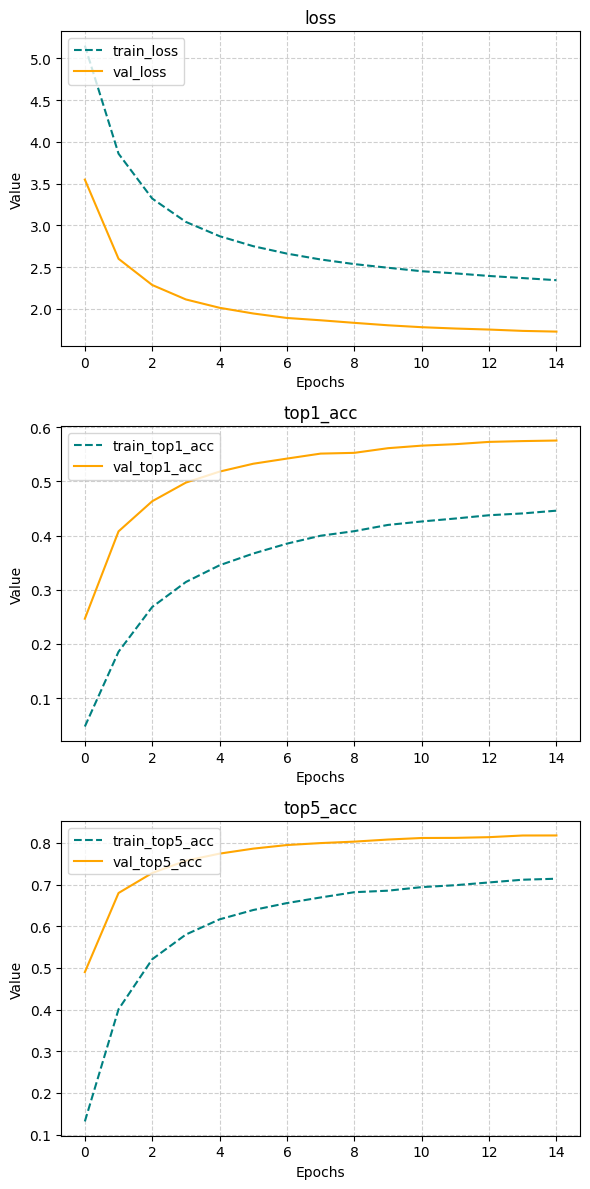

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.6783 - top1_acc: 0.5921 - top5_acc: 0.8205

| loss: 1.7277 | top1_acc: 0.5753 | top5_acc: 0.8177


 33%|███▎      | 1/3 [56:17<1:52:35, 3377.51s/it]

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

=== Training ResNet50 ===

Epoch 1/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.5911 - top1_acc: 0.1074 - top5_acc: 0.2438
Epoch 1: val_loss improved from inf to 1.87114, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 253s 76ms/step - loss: 4.5908 - top1_acc: 0.1074 - top5_acc: 0.2438 - val_loss: 1.8711 - val_top1_acc: 0.5760 - val_top5_acc: 0.8183 - learning_rate: 1.0000e-04
Epoch 2/15
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.7664 - top1_acc: 0.3780 - top5_acc: 0.6391
Epoch 2: val_loss improved from 1.87114 to 1.55674, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 2.7663 - top1_acc: 0.3781 - top5_acc: 0.6391 - val_loss: 1.5567 - val_top1_acc: 0.6253 - val_top5_acc: 0.8551 - learning_rate: 1.0000e-04
Epoch 3/15
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.4086 - top1_acc: 0.4429 - top5_acc: 0.7026
Epoch 3: val_loss improved from 1.55674 to 1.43609, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 71ms/step - loss: 2.4085 - top1_acc: 0.4430 - top5_acc: 0.7026 - val_loss: 1.4361 - val_top1_acc: 0.6506 - val_top5_acc: 0.8666 - learning_rate: 1.0000e-04
Epoch 4/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.2461 - top1_acc: 0.4737 - top5_acc: 0.7325
Epoch 4: val_loss improved from 1.43609 to 1.37015, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 71ms/step - loss: 2.2461 - top1_acc: 0.4737 - top5_acc: 0.7325 - val_loss: 1.3702 - val_top1_acc: 0.6623 - val_top5_acc: 0.8774 - learning_rate: 1.0000e-04
Epoch 5/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.1489 - top1_acc: 0.4938 - top5_acc: 0.7503
Epoch 5: val_loss improved from 1.37015 to 1.33764, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 2.1489 - top1_acc: 0.4938 - top5_acc: 0.7503 - val_loss: 1.3376 - val_top1_acc: 0.6695 - val_top5_acc: 0.8822 - learning_rate: 1.0000e-04
Epoch 6/15
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.0689 - top1_acc: 0.5104 - top5_acc: 0.7621
Epoch 6: val_loss improved from 1.33764 to 1.31091, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 225s 72ms/step - loss: 2.0689 - top1_acc: 0.5104 - top5_acc: 0.7621 - val_loss: 1.3109 - val_top1_acc: 0.6786 - val_top5_acc: 0.8838 - learning_rate: 1.0000e-04
Epoch 7/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.0254 - top1_acc: 0.5222 - top5_acc: 0.7695
Epoch 7: val_loss improved from 1.31091 to 1.29737, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 2.0254 - top1_acc: 0.5222 - top5_acc: 0.7695 - val_loss: 1.2974 - val_top1_acc: 0.6788 - val_top5_acc: 0.8840 - learning_rate: 1.0000e-04
Epoch 8/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.9802 - top1_acc: 0.5297 - top5_acc: 0.7771
Epoch 8: val_loss improved from 1.29737 to 1.27477, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 1.9802 - top1_acc: 0.5297 - top5_acc: 0.7771 - val_loss: 1.2748 - val_top1_acc: 0.6856 - val_top5_acc: 0.8873 - learning_rate: 1.0000e-04
Epoch 9/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.9374 - top1_acc: 0.5403 - top5_acc: 0.7850
Epoch 9: val_loss improved from 1.27477 to 1.25978, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 1.9374 - top1_acc: 0.5403 - top5_acc: 0.7850 - val_loss: 1.2598 - val_top1_acc: 0.6851 - val_top5_acc: 0.8888 - learning_rate: 1.0000e-04
Epoch 10/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.9035 - top1_acc: 0.5443 - top5_acc: 0.7912
Epoch 10: val_loss improved from 1.25978 to 1.24741, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 1.9035 - top1_acc: 0.5443 - top5_acc: 0.7912 - val_loss: 1.2474 - val_top1_acc: 0.6904 - val_top5_acc: 0.8902 - learning_rate: 1.0000e-04
Epoch 11/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8708 - top1_acc: 0.5550 - top5_acc: 0.7954
Epoch 11: val_loss improved from 1.24741 to 1.23796, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 1.8708 - top1_acc: 0.5550 - top5_acc: 0.7954 - val_loss: 1.2380 - val_top1_acc: 0.6936 - val_top5_acc: 0.8936 - learning_rate: 1.0000e-04
Epoch 12/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8650 - top1_acc: 0.5550 - top5_acc: 0.7960
Epoch 12: val_loss improved from 1.23796 to 1.23481, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 225s 72ms/step - loss: 1.8650 - top1_acc: 0.5550 - top5_acc: 0.7960 - val_loss: 1.2348 - val_top1_acc: 0.6934 - val_top5_acc: 0.8930 - learning_rate: 1.0000e-04
Epoch 13/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8461 - top1_acc: 0.5582 - top5_acc: 0.7990
Epoch 13: val_loss improved from 1.23481 to 1.22650, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 71ms/step - loss: 1.8461 - top1_acc: 0.5582 - top5_acc: 0.7990 - val_loss: 1.2265 - val_top1_acc: 0.6968 - val_top5_acc: 0.8948 - learning_rate: 1.0000e-04
Epoch 14/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8204 - top1_acc: 0.5641 - top5_acc: 0.8051
Epoch 14: val_loss improved from 1.22650 to 1.22255, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 1.8205 - top1_acc: 0.5641 - top5_acc: 0.8051 - val_loss: 1.2226 - val_top1_acc: 0.6940 - val_top5_acc: 0.8954 - learning_rate: 1.0000e-04
Epoch 15/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.7960 - top1_acc: 0.5692 - top5_acc: 0.8089
Epoch 15: val_loss improved from 1.22255 to 1.21633, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 1.7961 - top1_acc: 0.5692 - top5_acc: 0.8089 - val_loss: 1.2163 - val_top1_acc: 0.6974 - val_top5_acc: 0.8968 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.
Training time of ResNet50: 56.58 minutes



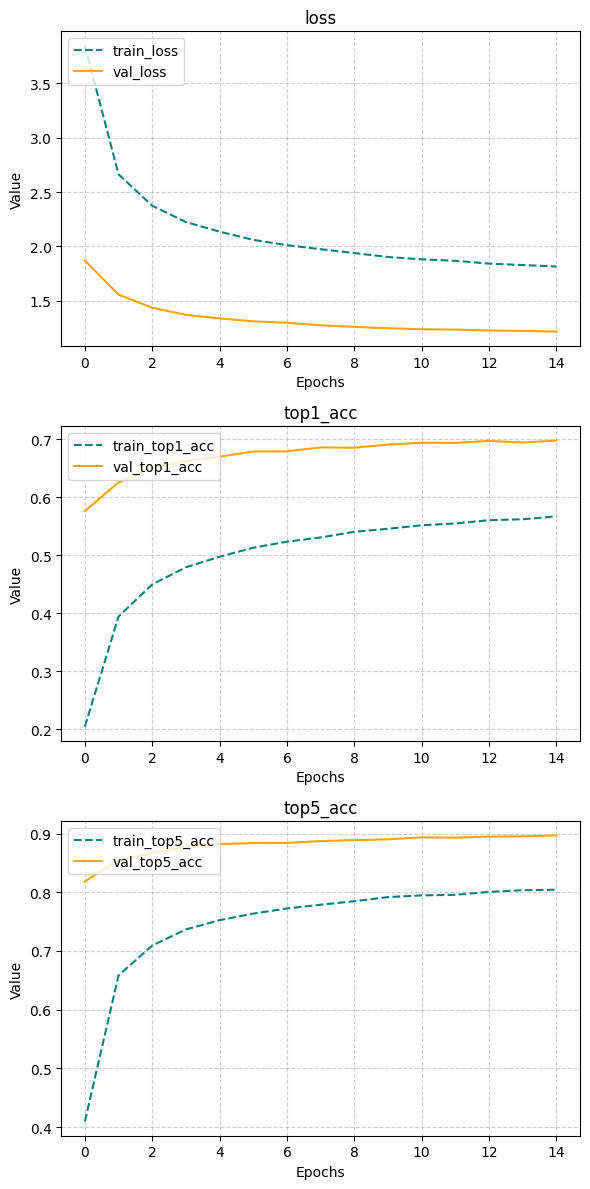

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.1333 - top1_acc: 0.7110 - top5_acc: 0.9090

| loss: 1.2163 | top1_acc: 0.6974 | top5_acc: 0.8968


 67%|██████▋   | 2/3 [1:53:40<56:55, 3415.95s/it]

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

=== Training EfficientNetB0 ===

Epoch 1/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.5479 - top1_acc: 0.1272 - top5_acc: 0.2754
Epoch 1: val_loss improved from inf to 2.12983, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 289s 80ms/step - loss: 4.5477 - top1_acc: 0.1272 - top5_acc: 0.2754 - val_loss: 2.1298 - val_top1_acc: 0.6034 - val_top5_acc: 0.8299 - learning_rate: 1.0000e-04
Epoch 2/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.7305 - top1_acc: 0.3976 - top5_acc: 0.6627
Epoch 2: val_loss improved from 2.12983 to 1.63991, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 2.7305 - top1_acc: 0.3976 - top5_acc: 0.6627 - val_loss: 1.6399 - val_top1_acc: 0.6437 - val_top5_acc: 0.8626 - learning_rate: 1.0000e-04
Epoch 3/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.3791 - top1_acc: 0.4612 - top5_acc: 0.7197
Epoch 3: val_loss improved from 1.63991 to 1.47758, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.3791 - top1_acc: 0.4612 - top5_acc: 0.7197 - val_loss: 1.4776 - val_top1_acc: 0.6646 - val_top5_acc: 0.8745 - learning_rate: 1.0000e-04
Epoch 4/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.2267 - top1_acc: 0.4884 - top5_acc: 0.7455
Epoch 4: val_loss improved from 1.47758 to 1.39405, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 2.2267 - top1_acc: 0.4884 - top5_acc: 0.7455 - val_loss: 1.3941 - val_top1_acc: 0.6771 - val_top5_acc: 0.8809 - learning_rate: 1.0000e-04
Epoch 5/15
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.1331 - top1_acc: 0.5093 - top5_acc: 0.7585
Epoch 5: val_loss improved from 1.39405 to 1.34733, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 2.1330 - top1_acc: 0.5093 - top5_acc: 0.7585 - val_loss: 1.3473 - val_top1_acc: 0.6873 - val_top5_acc: 0.8881 - learning_rate: 1.0000e-04
Epoch 6/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.0567 - top1_acc: 0.5241 - top5_acc: 0.7706
Epoch 6: val_loss improved from 1.34733 to 1.31003, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 2.0567 - top1_acc: 0.5241 - top5_acc: 0.7706 - val_loss: 1.3100 - val_top1_acc: 0.6903 - val_top5_acc: 0.8896 - learning_rate: 1.0000e-04
Epoch 7/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.0102 - top1_acc: 0.5350 - top5_acc: 0.7784
Epoch 7: val_loss improved from 1.31003 to 1.29149, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 2.0102 - top1_acc: 0.5350 - top5_acc: 0.7784 - val_loss: 1.2915 - val_top1_acc: 0.6959 - val_top5_acc: 0.8917 - learning_rate: 1.0000e-04
Epoch 8/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.9816 - top1_acc: 0.5410 - top5_acc: 0.7817
Epoch 8: val_loss improved from 1.29149 to 1.26889, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 1.9816 - top1_acc: 0.5410 - top5_acc: 0.7817 - val_loss: 1.2689 - val_top1_acc: 0.6997 - val_top5_acc: 0.8941 - learning_rate: 1.0000e-04
Epoch 9/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.9433 - top1_acc: 0.5498 - top5_acc: 0.7865
Epoch 9: val_loss improved from 1.26889 to 1.25703, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 1.9433 - top1_acc: 0.5498 - top5_acc: 0.7865 - val_loss: 1.2570 - val_top1_acc: 0.7026 - val_top5_acc: 0.8956 - learning_rate: 1.0000e-04
Epoch 10/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.9162 - top1_acc: 0.5546 - top5_acc: 0.7910
Epoch 10: val_loss improved from 1.25703 to 1.24519, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 1.9162 - top1_acc: 0.5546 - top5_acc: 0.7910 - val_loss: 1.2452 - val_top1_acc: 0.7065 - val_top5_acc: 0.8971 - learning_rate: 1.0000e-04
Epoch 11/15
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8877 - top1_acc: 0.5618 - top5_acc: 0.7972
Epoch 11: val_loss improved from 1.24519 to 1.23830, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 1.8877 - top1_acc: 0.5618 - top5_acc: 0.7972 - val_loss: 1.2383 - val_top1_acc: 0.7066 - val_top5_acc: 0.8987 - learning_rate: 1.0000e-04
Epoch 12/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8765 - top1_acc: 0.5625 - top5_acc: 0.7989
Epoch 12: val_loss improved from 1.23830 to 1.22563, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 1.8765 - top1_acc: 0.5625 - top5_acc: 0.7989 - val_loss: 1.2256 - val_top1_acc: 0.7103 - val_top5_acc: 0.8987 - learning_rate: 1.0000e-04
Epoch 13/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8513 - top1_acc: 0.5694 - top5_acc: 0.8020
Epoch 13: val_loss improved from 1.22563 to 1.21636, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - loss: 1.8513 - top1_acc: 0.5694 - top5_acc: 0.8020 - val_loss: 1.2164 - val_top1_acc: 0.7102 - val_top5_acc: 0.9004 - learning_rate: 1.0000e-04
Epoch 14/15
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8397 - top1_acc: 0.5726 - top5_acc: 0.8039
Epoch 14: val_loss improved from 1.21636 to 1.21508, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 1.8398 - top1_acc: 0.5726 - top5_acc: 0.8039 - val_loss: 1.2151 - val_top1_acc: 0.7110 - val_top5_acc: 0.8999 - learning_rate: 1.0000e-04
Epoch 15/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8311 - top1_acc: 0.5740 - top5_acc: 0.8068
Epoch 15: val_loss improved from 1.21508 to 1.21106, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 1.8311 - top1_acc: 0.5740 - top5_acc: 0.8068 - val_loss: 1.2111 - val_top1_acc: 0.7119 - val_top5_acc: 0.8999 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.
Training time of EfficientNetB0: 56.74 minutes



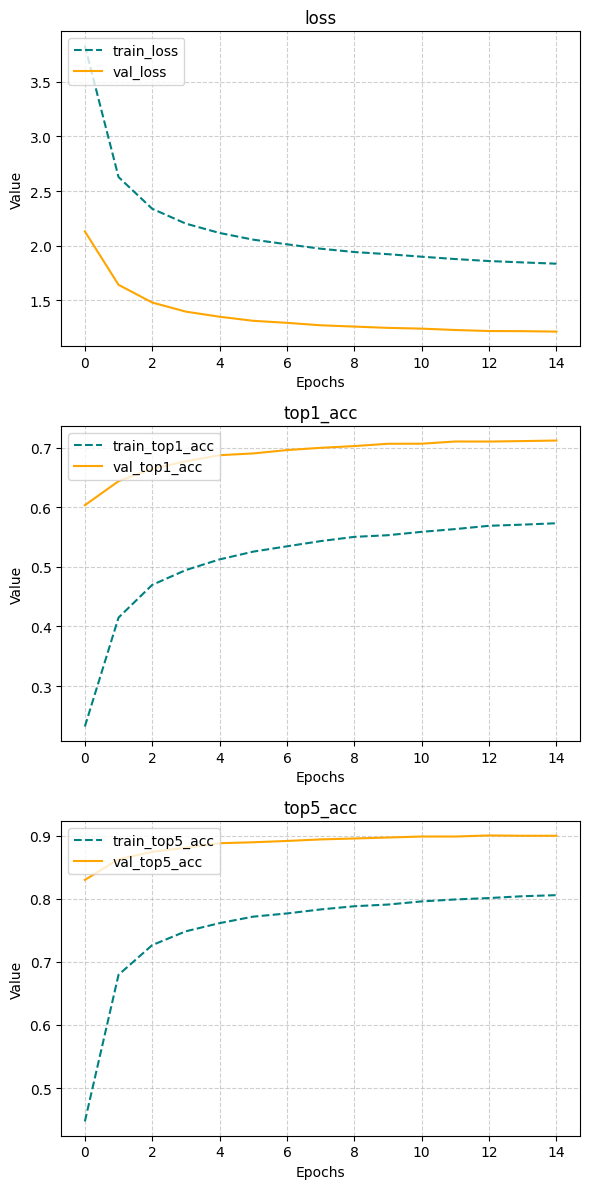

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 1.1323 - top1_acc: 0.7313 - top5_acc: 0.9098

| loss: 1.2111 | top1_acc: 0.7119 | top5_acc: 0.8999


100%|██████████| 3/3 [2:51:12<00:00, 3424.19s/it]


In [21]:
for name, (base, preprocess_input) in tqdm(transfer_models.items()):
  model_transfer = build_transfer_model(base, preprocess_input, name)

  history_transfer, row_transfer = train_and_evaluate(
      model_transfer, name,
      tf_train, tf_valid,
      epochs=15, mode='Transfer Learning'
  )

  models[name] = model_transfer
  histories[name] = history_transfer
  final_table.append(row_transfer)

results_df = pd.DataFrame(final_table)
path = os.path.join('/content/drive/MyDrive/', 'trainingdf_lab1-omss.csv')
results_df.to_csv(path, index=False)

# Fine Tuning


=== Fine-tuning VGG16 - Fine-tune ===

=== Training VGG16 - Fine-tune ===

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.2258 - top1_acc: 0.4704 - top5_acc: 0.7363
Epoch 1: val_loss improved from inf to 1.61108, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 232s 72ms/step - loss: 2.2257 - top1_acc: 0.4704 - top5_acc: 0.7363 - val_loss: 1.6111 - val_top1_acc: 0.6046 - val_top5_acc: 0.8403 - learning_rate: 1.0000e-05
Epoch 2/5
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.0301 - top1_acc: 0.5121 - top5_acc: 0.7706
Epoch 2: val_loss improved from 1.61108 to 1.57139, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 223s 71ms/step - loss: 2.0301 - top1_acc: 0.5121 - top5_acc: 0.7706 - val_loss: 1.5714 - val_top1_acc: 0.6163 - val_top5_acc: 0.8448 - learning_rate: 1.0000e-05
Epoch 3/5
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.9463 - top1_acc: 0.5289 - top5_acc: 0.7841
Epoch 3: val_loss improved from 1.57139 to 1.51685, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 71ms/step - loss: 1.9462 - top1_acc: 0.5289 - top5_acc: 0.7841 - val_loss: 1.5168 - val_top1_acc: 0.6277 - val_top5_acc: 0.8489 - learning_rate: 1.0000e-05
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8549 - top1_acc: 0.5487 - top5_acc: 0.7980
Epoch 4: val_loss improved from 1.51685 to 1.49547, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 71ms/step - loss: 1.8549 - top1_acc: 0.5487 - top5_acc: 0.7980 - val_loss: 1.4955 - val_top1_acc: 0.6299 - val_top5_acc: 0.8546 - learning_rate: 1.0000e-05
Epoch 5/5
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8027 - top1_acc: 0.5619 - top5_acc: 0.8073
Epoch 5: val_loss improved from 1.49547 to 1.47998, saving model to /content/drive/MyDrive/checkpoints/best_model_VGG16 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 225s 72ms/step - loss: 1.8027 - top1_acc: 0.5619 - top5_acc: 0.8073 - val_loss: 1.4800 - val_top1_acc: 0.6347 - val_top5_acc: 0.8558 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.
Training time of VGG16 - Fine-tune: 18.79 minutes



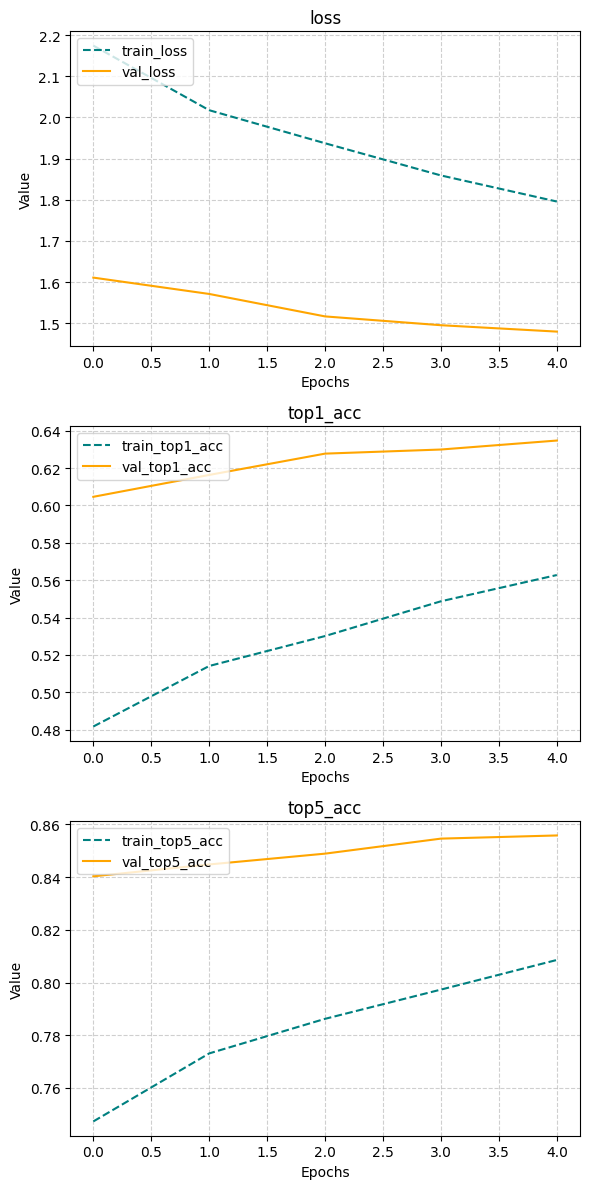

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.3736 - top1_acc: 0.6576 - top5_acc: 0.8686

| loss: 1.4800 | top1_acc: 0.6347 | top5_acc: 0.8558

=== Fine-tuning ResNet50 - Fine-tune ===

=== Training ResNet50 - Fine-tune ===

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.7866 - top1_acc: 0.5769 - top5_acc: 0.8120
Epoch 1: val_loss improved from inf to 1.10129, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 259s 74ms/step - loss: 1.7866 - top1_acc: 0.5769 - top5_acc: 0.8120 - val_loss: 1.1013 - val_top1_acc: 0.7276 - val_top5_acc: 0.9103 - learning_rate: 1.0000e-05
Epoch 2/5
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4936 - top1_acc: 0.6397 - top5_acc: 0.8563
Epoch 2: val_loss improved from 1.10129 to 1.07107, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 228s 73ms/step - loss: 1.4936 - top1_acc: 0.6397 - top5_acc: 0.8563 - val_loss: 1.0711 - val_top1_acc: 0.7383 - val_top5_acc: 0.9129 - learning_rate: 1.0000e-05
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.3923 - top1_acc: 0.6607 - top5_acc: 0.8698
Epoch 3: val_loss improved from 1.07107 to 1.04459, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 230s 73ms/step - loss: 1.3923 - top1_acc: 0.6607 - top5_acc: 0.8698 - val_loss: 1.0446 - val_top1_acc: 0.7426 - val_top5_acc: 0.9166 - learning_rate: 1.0000e-05
Epoch 4/5
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.3031 - top1_acc: 0.6808 - top5_acc: 0.8833
Epoch 4: val_loss improved from 1.04459 to 1.03246, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 230s 73ms/step - loss: 1.3031 - top1_acc: 0.6808 - top5_acc: 0.8833 - val_loss: 1.0325 - val_top1_acc: 0.7481 - val_top5_acc: 0.9187 - learning_rate: 1.0000e-05
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.2284 - top1_acc: 0.6987 - top5_acc: 0.8918
Epoch 5: val_loss improved from 1.03246 to 1.01869, saving model to /content/drive/MyDrive/checkpoints/best_model_ResNet50 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 229s 73ms/step - loss: 1.2284 - top1_acc: 0.6987 - top5_acc: 0.8918 - val_loss: 1.0187 - val_top1_acc: 0.7548 - val_top5_acc: 0.9201 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.
Training time of ResNet50 - Fine-tune: 19.59 minutes



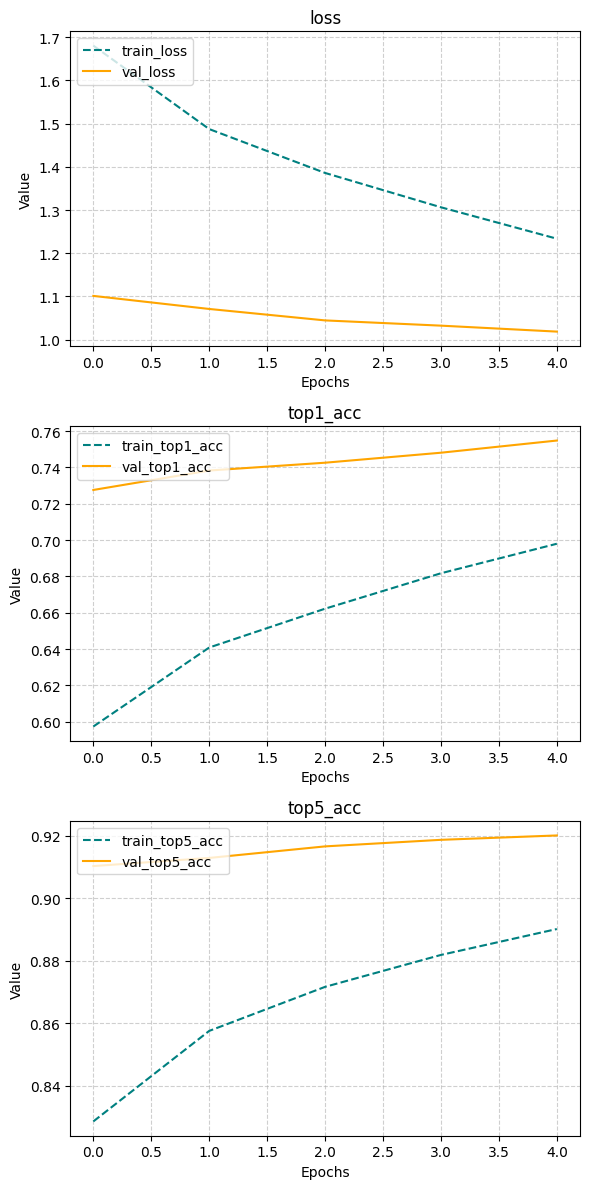

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.9412 - top1_acc: 0.7706 - top5_acc: 0.9271

| loss: 1.0187 | top1_acc: 0.7548 | top5_acc: 0.9201

=== Fine-tuning EfficientNetB0 - Fine-tune ===

=== Training EfficientNetB0 - Fine-tune ===

Epoch 1/5
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.1737 - top1_acc: 0.5351 - top5_acc: 0.7745
Epoch 1: val_loss improved from inf to 1.13373, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 272s 75ms/step - loss: 2.1736 - top1_acc: 0.5351 - top5_acc: 0.7745 - val_loss: 1.1337 - val_top1_acc: 0.7332 - val_top5_acc: 0.9078 - learning_rate: 1.0000e-05
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8055 - top1_acc: 0.5829 - top5_acc: 0.8175
Epoch 2: val_loss improved from 1.13373 to 1.08959, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 71ms/step - loss: 1.8055 - top1_acc: 0.5829 - top5_acc: 0.8175 - val_loss: 1.0896 - val_top1_acc: 0.7402 - val_top5_acc: 0.9115 - learning_rate: 1.0000e-05
Epoch 3/5
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.7346 - top1_acc: 0.5971 - top5_acc: 0.8235
Epoch 3: val_loss improved from 1.08959 to 1.06899, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 1.7346 - top1_acc: 0.5971 - top5_acc: 0.8235 - val_loss: 1.0690 - val_top1_acc: 0.7433 - val_top5_acc: 0.9150 - learning_rate: 1.0000e-05
Epoch 4/5
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.6765 - top1_acc: 0.6106 - top5_acc: 0.8317
Epoch 4: val_loss improved from 1.06899 to 1.04927, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 72ms/step - loss: 1.6765 - top1_acc: 0.6106 - top5_acc: 0.8317 - val_loss: 1.0493 - val_top1_acc: 0.7479 - val_top5_acc: 0.9169 - learning_rate: 1.0000e-05
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.6388 - top1_acc: 0.6144 - top5_acc: 0.8387
Epoch 5: val_loss improved from 1.04927 to 1.03960, saving model to /content/drive/MyDrive/checkpoints/best_model_EfficientNetB0 - Fine-tune.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 224s 71ms/step - loss: 1.6388 - top1_acc: 0.6144 - top5_acc: 0.8387 - val_loss: 1.0396 - val_top1_acc: 0.7504 - val_top5_acc: 0.9182 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.
Training time of EfficientNetB0 - Fine-tune: 19.49 minutes



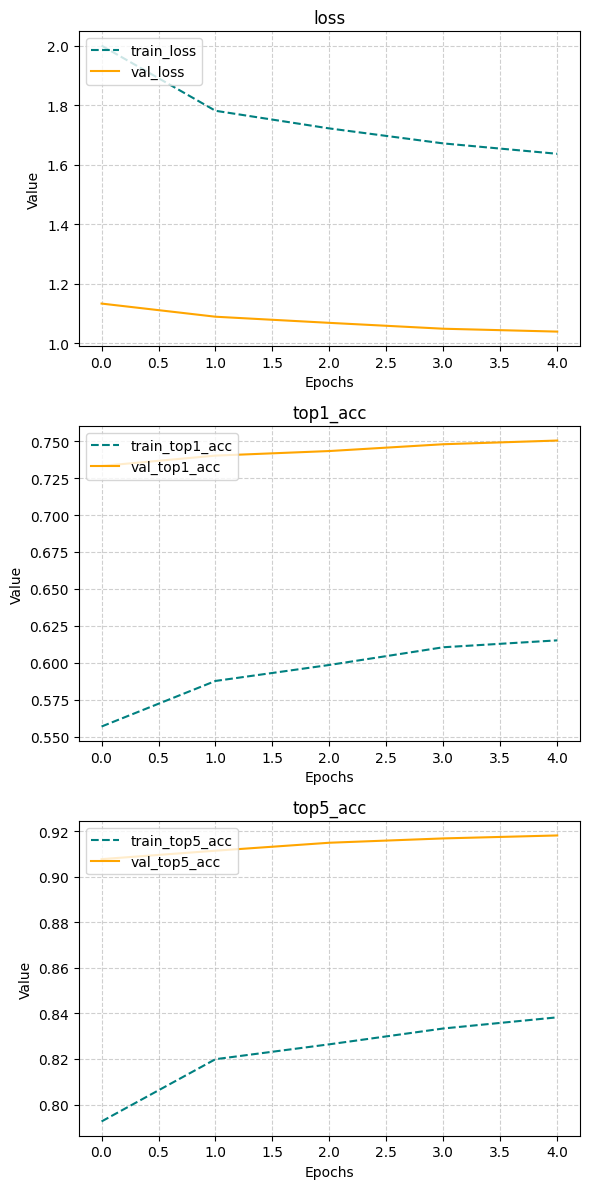

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.9567 - top1_acc: 0.7683 - top5_acc: 0.9270

| loss: 1.0396 | top1_acc: 0.7504 | top5_acc: 0.9182


In [22]:
for name, model in models.items():
  ft_name = f"{name} - Fine-tune"
  print(f"\n=== Fine-tuning {ft_name} ===")

  base_model = None
  for layer in model.layers:
    if isinstance(layer, tf.keras.Model):
      base_model = layer
      break

  # размораживаем верхние слои
  if name == 'VGG16':
    for layer in base_model.layers[:-4]:
      layer.trainable = False
    for layer in base_model.layers[-4:]:
      layer.trainable = True
  elif name == "ResNet50":
    for layer in base_model.layers[:-50]:
      layer.trainable = False
    for layer in base_model.layers[-50:]:
      layer.trainable = True
  elif name == "EfficientNetB0":
    for layer in base_model.layers[:-50]:
      layer.trainable = False
    for layer in base_model.layers[-50:]:
      layer.trainable = True

  model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), # smaller learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='top1_acc'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')
    ]
  )

  # train with fine-tuning
  history_ft, row_ft = train_and_evaluate(
      model, ft_name,
      tf_train, tf_valid,
      epochs=5, mode='Fine-Tuning'
  )

  models[name] = model
  histories[name] = history_ft
  final_table.append(row_ft)

results_df = pd.DataFrame(final_table)
path = os.path.join('/content/drive/MyDrive/', 'trainingdf_lab1-omss.csv')
results_df.to_csv(path, index=False)

# Testing & Evaluating

In [21]:
transfer_model_paths = [
    f"/content/drive/MyDrive/checkpoints/best_model_{name}.h5"
    for name in transfer_models.keys()
]

ft_model_paths = [
    f"/content/drive/MyDrive/checkpoints/best_model_{name} - Fine-tune.h5"
    for name in transfer_models.keys()
]

model_paths = transfer_model_paths + ft_model_paths
model_names = list(transfer_models.keys()) + [f"{name} - Fine-tune" for name in transfer_models.keys()]

In [22]:
print("Model paths:")
for p in model_paths:
    print(p)

print("\nModel names:")
for n in model_names:
    print(n)

Model paths:
/content/drive/MyDrive/checkpoints/best_model_VGG16.h5
/content/drive/MyDrive/checkpoints/best_model_ResNet50.h5
/content/drive/MyDrive/checkpoints/best_model_EfficientNetB0.h5
/content/drive/MyDrive/checkpoints/best_model_VGG16 - Fine-tune.h5
/content/drive/MyDrive/checkpoints/best_model_ResNet50 - Fine-tune.h5
/content/drive/MyDrive/checkpoints/best_model_EfficientNetB0 - Fine-tune.h5

Model names:
VGG16
ResNet50
EfficientNetB0
VGG16 - Fine-tune
ResNet50 - Fine-tune
EfficientNetB0 - Fine-tune


In [23]:
for name, (_, preprocess_input) in transfer_models.items():
    custom_objects_map[f"{name} - Fine-tune"] = {"preprocess_input": preprocess_input}


=== Evaluating VGG16 ===


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step

--- VGG16 ---
Accuracy: 0.5753 | F1 Score: 0.5728 | AUC: 0.9835


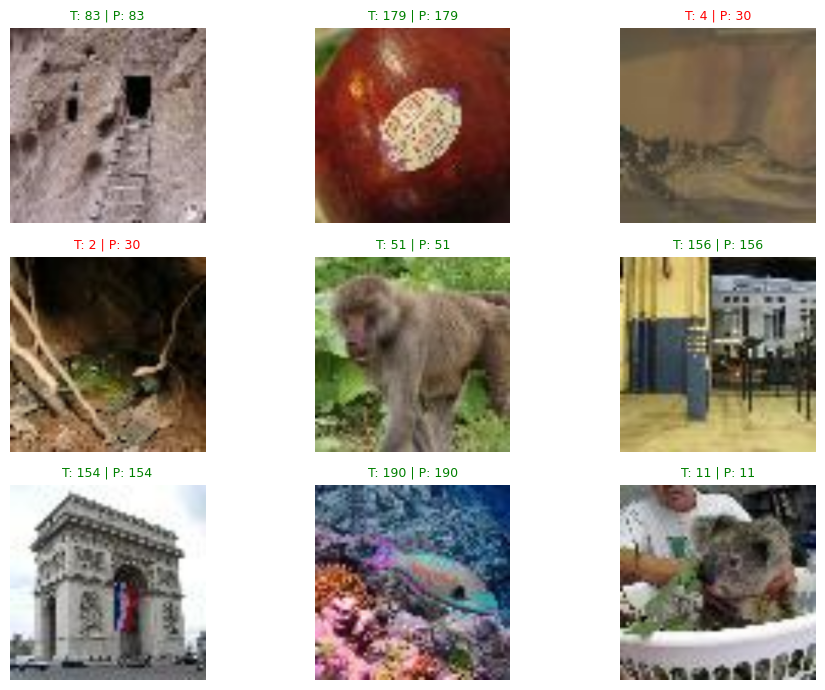


=== Evaluating ResNet50 ===


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step

--- ResNet50 ---
Accuracy: 0.6974 | F1 Score: 0.6969 | AUC: 0.9929


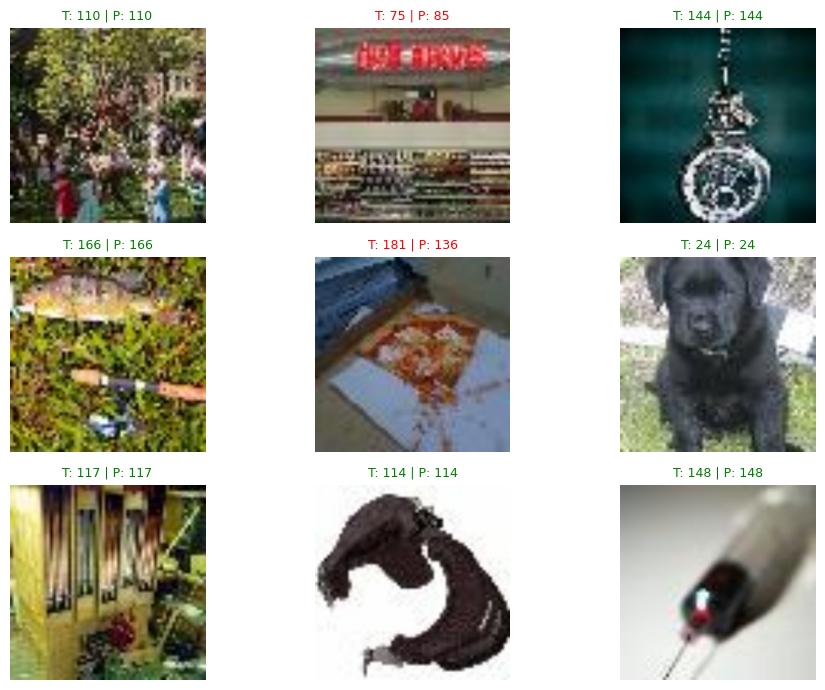


=== Evaluating EfficientNetB0 ===


313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step

--- EfficientNetB0 ---
Accuracy: 0.5835 | F1 Score: 0.5917 | AUC: 0.9844


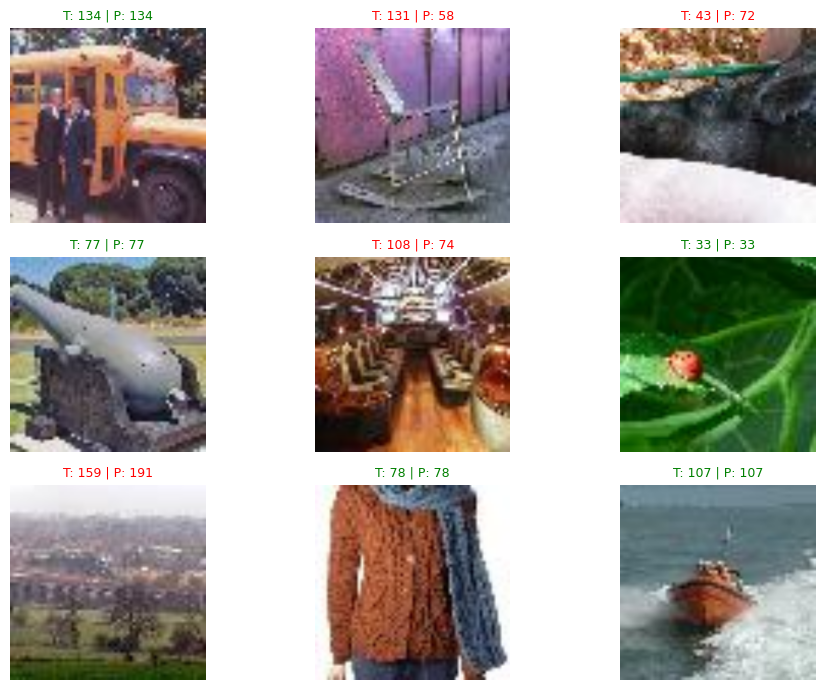


=== Evaluating VGG16 - Fine-tune ===


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step

--- VGG16 - Fine-tune ---
Accuracy: 0.6347 | F1 Score: 0.6330 | AUC: 0.9881


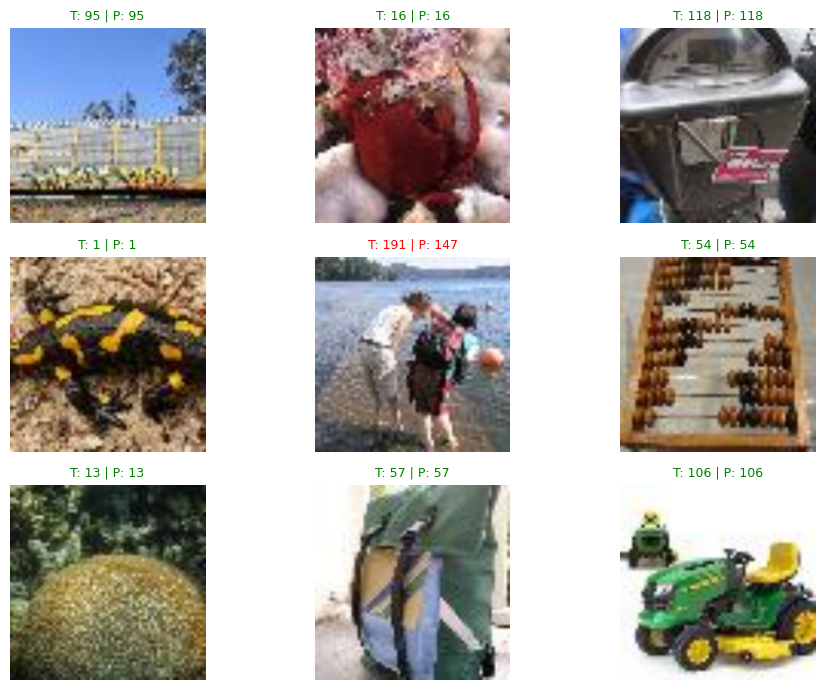


=== Evaluating ResNet50 - Fine-tune ===


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step

--- ResNet50 - Fine-tune ---
Accuracy: 0.7548 | F1 Score: 0.7544 | AUC: 0.9948


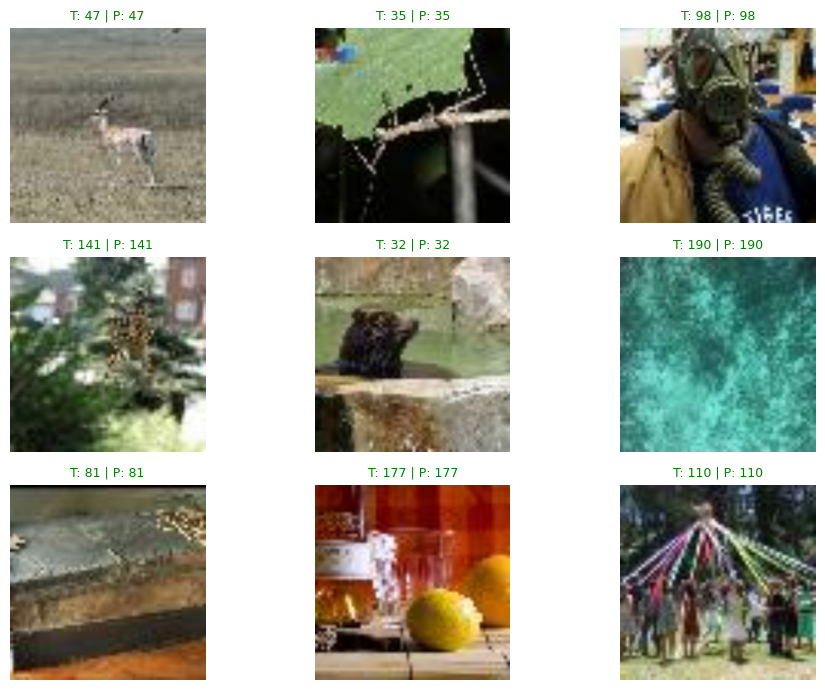


=== Evaluating EfficientNetB0 - Fine-tune ===


313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step

--- EfficientNetB0 - Fine-tune ---
Accuracy: 0.6278 | F1 Score: 0.6327 | AUC: 0.9876


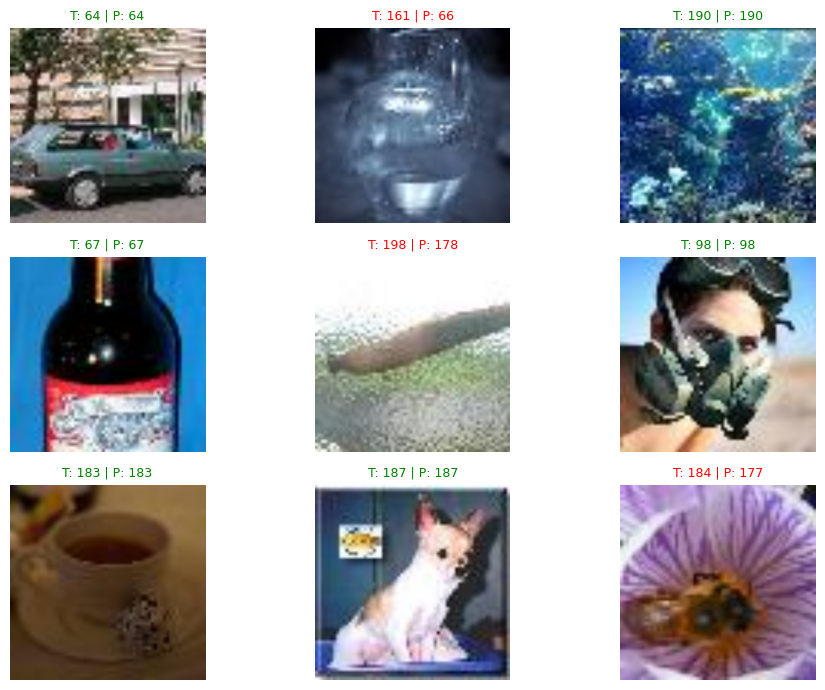


--- Results updated and saved to /content/drive/MyDrive/testingdf_lab1-omms.csv ---


Model  Accuracy        F1       AUC
0                       VGG16    0.5753  0.572774  0.983540
1                    ResNet50    0.6974  0.696902  0.992894
2              EfficientNetB0    0.5835  0.591653  0.984411
3           VGG16 - Fine-tune    0.6347  0.633021  0.988054
4        ResNet50 - Fine-tune    0.7548  0.754413  0.994777
5  EfficientNetB0 - Fine-tune    0.6278  0.632670  0.987566

In [25]:
df_test_results = test_and_evaluate(model_paths, model_names, tf_valid, n_images=9)
df_test_results

# Saliency Map

In [56]:
def saliency_maps(model, tf_valid, n_images=2):
  images, labels = [], []
  for img, lbl in tf_valid:
    images.append(img.numpy())
    labels.append(np.argmax(lbl.numpy(), axis=-1))
  images = np.vstack(images)
  labels = np.concatenate(labels)

  idxs = np.random.choice(len(images), size=n_images, replace=False)

  # Saliency object
  saliency = Saliency(
      model,
      model_modifier=ReplaceToLinear(), #  swap last layer with linear layer
      clone=False
  )

  n_rows = n_images
  n_cols = 2
  plt.figure(figsize=(4*n_cols, 4*n_rows))

  for plot_i, i in enumerate(idxs):
    image = images[i:i+1]
    true_label = labels[i]

    score = CategoricalScore([true_label]) # True class
    # saliency map
    saliency_map = saliency(score, image, smooth_samples=20, smooth_noise=0.2)

    plt.subplot(n_rows, n_cols, plot_i * 2 + 1)
    plt.imshow(image[0].astype("uint8"))
    plt.axis("off")
    plt.title(f"{true_label}")

    plt.subplot(n_rows, n_cols, plot_i * 2 + 2)
    plt.imshow(saliency_map[0], cmap='jet')
    plt.axis("off")
    plt.title("Saliency Map")

  plt.tight_layout()
  plt.show()


=== Saliency Map for VGG16 ===


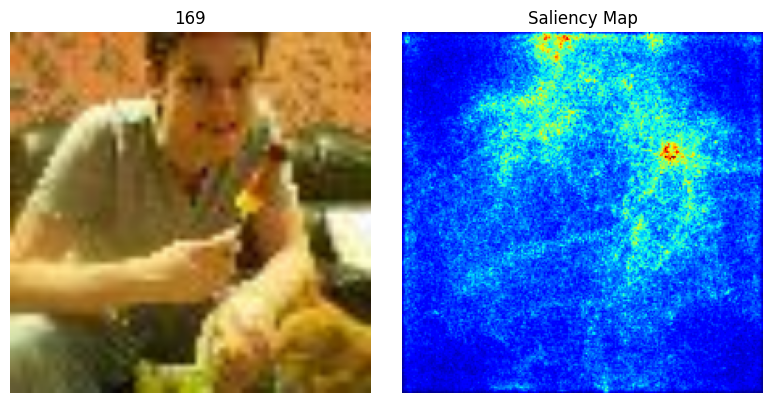


=== Saliency Map for ResNet50 ===


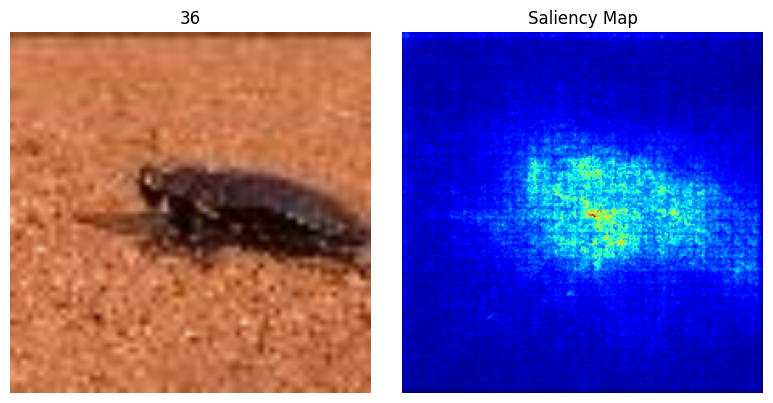


=== Saliency Map for EfficientNetB0 ===


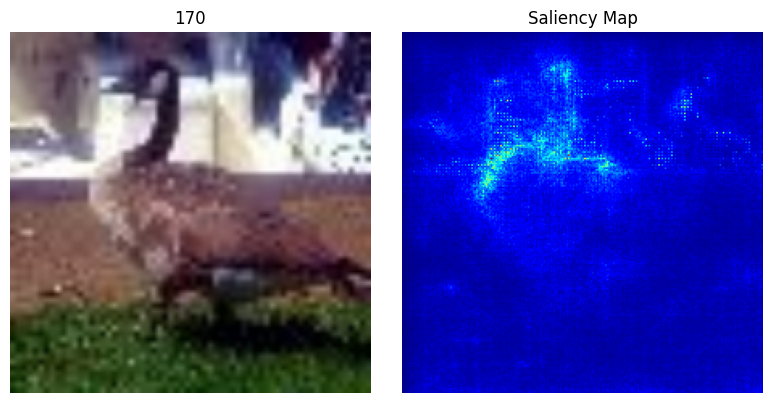


=== Saliency Map for VGG16 - Fine-tune ===


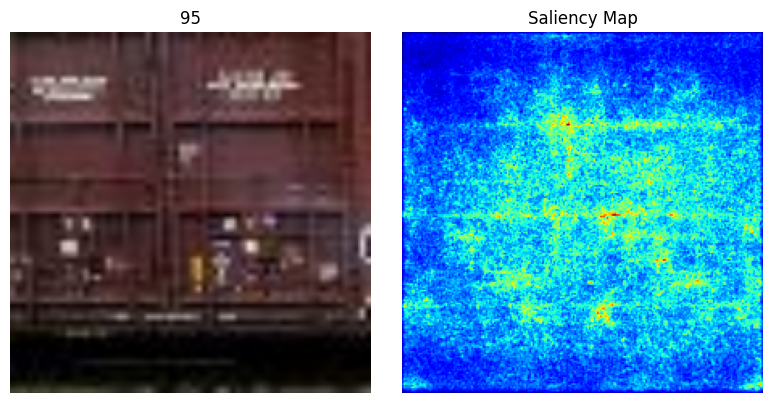


=== Saliency Map for ResNet50 - Fine-tune ===


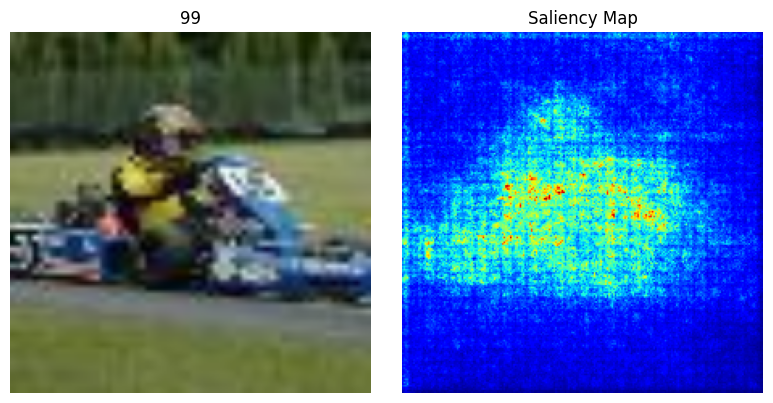


=== Saliency Map for EfficientNetB0 - Fine-tune ===


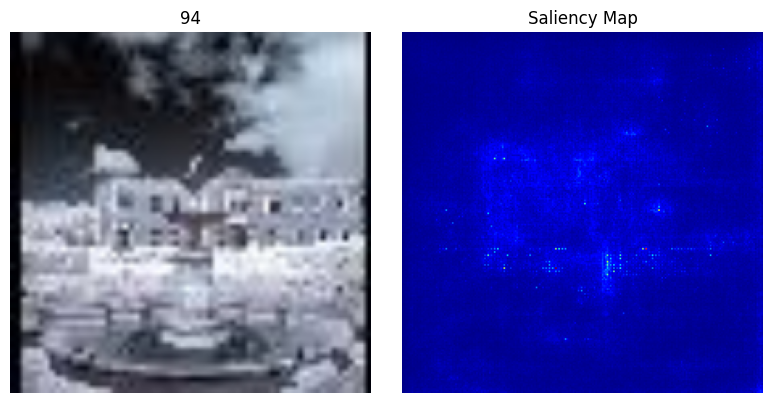

In [59]:
for path, name in zip(model_paths, model_names):
  print(f"\n=== Saliency Map for {name} ===")
  model = tf.keras.models.load_model(
      path, custom_objects=custom_objects_map[name]
  )
  saliency_maps(model, tf_valid, n_images=1)

# Results

In [58]:
df = pd.read_csv('/content/drive/MyDrive/trainingdf_lab1-omss.csv')
results_df = pd.DataFrame(df)
results_df

Name               Mode      Loss  Top1 Acc  \
0                       VGG16  Transfer Learning  1.727657    0.5753   
1                    ResNet50  Transfer Learning  1.216330    0.6974   
2              EfficientNetB0  Transfer Learning  1.211061    0.7119   
3           VGG16 - Fine-tune        Fine-Tuning  1.479979    0.6347   
4        ResNet50 - Fine-tune        Fine-Tuning  1.018691    0.7548   
5  EfficientNetB0 - Fine-tune        Fine-Tuning  1.039603    0.7504   

   Top5 Acc  Train Time (m)  Params (M)  FLOPs (G)  Memory (MB)  \
0    0.8177       55.926732   14.897416        NaN    57.403351   
1    0.8968       56.578031   24.163656        NaN    92.751251   
2    0.8999       56.743697    4.428907        NaN    17.469158   
3    0.8558       18.789440   14.897416        NaN    57.403351   
4    0.9201       19.586057   24.163656        NaN    92.751251   
5    0.9182       19.486342    4.428907        NaN    17.469158   

   Latency CPU (ms)  Latency GPU (ms)  Efficiency Ratio CPU  \
0        120.962175         27.853167              0.423452   
1        338.548416        224.288563              0.192274   
2        352.967589        271.336544              0.199191   
3        126.104960         28.390690              0.450134   
4        344.004267        227.068850              0.205015   
5        354.830710        274.647967              0.208874   

   Efficiency Ratio GPU  
0              1.345713  
1              0.280698  
2              0.258154  
3              1.466223  
4              0.300439  
5              0.268886

> - **Top-1 Accuracy:** before fine-tuning ~57–71%, after fine-tuning increased by 2–4%, with the best ~75% (ResNet50).
>- **Top-5 Accuracy:** before fine-tuning ~81–89%, after fine-tuning increased by 2–4%, with the best ~92% (ResNet50). EfficientNetB0 shows similar results to ResNet50, while VGG16 has the lowest performance.
> - **Loss:** ranges from 1 to 1.7; decreases after fine-tuning, best for ResNet50, worst for VGG16.
>- **Params (M):** EfficientNetB0 — 4M, VGG16 — 14.8M, ResNet50 — 24M.
>- **Memory (MB):** ResNet50 ~93, VGG16 ~57, EfficientNetB0 ~17.
>- **Latency CPU (ms):** VGG16 ~120–126, ResNet50 ~338–344, EfficientNetB0 ~353–355.
>- **Latency GPU (ms):** VGG16 ~28, ResNet50 ~224–227, EfficientNetB0 ~271–275.
>- **Efficiency Ratio CPU/GPU:** VGG16 is the most efficient on GPU (1.34–1.46), ResNet50 and EfficientNetB0 — 0.19–0.3.

**Summary:**
- VGG16: not the most accurate, but fastest and most efficient on GPU, moderate memory usage.
- **ResNet50:** most accurate, but heavy and slow, requires more memory and computation time.
- EfficientNetB0: low memory usage, high accuracy, but slightly slower on GPU compared to VGG16.

In [27]:
testing_table = pd.read_csv('/content/drive/MyDrive/testingdf_lab1-omms.csv')
testing_df = pd.DataFrame(testing_table)
testing_df

Model  Accuracy        F1       AUC
0                       VGG16    0.5753  0.572774  0.983540
1                    ResNet50    0.6974  0.696902  0.992894
2              EfficientNetB0    0.5835  0.591653  0.984411
3           VGG16 - Fine-tune    0.6347  0.633021  0.988054
4        ResNet50 - Fine-tune    0.7548  0.754413  0.994777
5  EfficientNetB0 - Fine-tune    0.6278  0.632670  0.987566

> - **Accuracy:**
>   - Before fine-tuning: VGG16 — 57.5%, ResNet50 — 69.7%, EfficientNetB0 — 58.3%.
>   - After fine-tuning: VGG16 — 63.5%, ResNet50 — 75.5%, EfficientNetB0 — 62.8%.
>   - The highest accuracy is achieved by ResNet50 (fine-tuned).
>- **F1 Score:**
>   - Relatively low before fine-tuning, lowest ~0.572.
>   - Best for ResNet50 — 0.754 (fine-tuned), lowest for VGG16 — 0.572 (before fine-tuning).
> - **AUC:**
>   - High values for all models (>0.98), indicating good class separability.
>   - Highest — 0.994 for ResNet50 (fine-tuned).

It can be noted that fine-tuning improves all metrics by 3–6%. **ResNet50** achieves the best results across all three metrics. Meanwhile, VGG16 and EfficientNetB0 are less accurate but still show high AUC, meaning the models can separate classes well even with lower overall accuracy.

In [ ]:
# # == Grid-Cam ==
# def run_gradcam(model_paths, model_names, tf_valid, transfer_models, num_images=3):
#   for path, name in zip(model_paths, model_names):
#     print(f"\n=== Grad-Cam for {name} ===")
#     model = tf.keras.models.load_model(path, custom_objects=custom_objects_map[name])
#     preprocess_input = transfer_models[name][1]
#     gradcam(model, tf_valid, preprocess_input, num_images=num_images)

# def gradcam(model, test_set, preprocess_input, last_conv_layer_name=None, num_images=3):
#     # если явно не указали, берём последний Conv2D слой
#   if last_conv_layer_name is None:
#       conv_layers = []
#       for layer in model.layers:
#           if isinstance(layer, tf.keras.layers.Conv2D):
#               conv_layers.append(layer.name)
#           elif isinstance(layer, tf.keras.Model):
#               for sublayer in layer.layers:
#                   if isinstance(sublayer, tf.keras.layers.Conv2D):
#                       conv_layers.append(sublayer.name)
#       if not conv_layers:
#           raise ValueError(f"No Conv2D layer found in {model.name}")
#       last_conv_layer_name = conv_layers[-1]

#   # ищем слой в base_model (например, vgg16 -> block5_conv3)
#   base_model_layer = None
#   for layer in model.layers:
#       if isinstance(layer, tf.keras.Model):  # например, vgg16
#           try:
#               base_model_layer = layer.get_layer(last_conv_layer_name)
#               break
#           except ValueError:
#               continue
#   if base_model_layer is None:
#       raise ValueError(f"Layer {last_conv_layer_name} not found in model {model.name}")

#   grad_model = tf.keras.models.Model(
#       inputs=model.input,
#       outputs=[base_model_layer.output, model.output]
#   )

#   batch = next(iter(test_set))
#   images, labels = batch
#   idxs = random.sample(range(len(images)), num_images)

#   for idx in idxs:
#       img = images[idx].numpy()
#       img_proc = np.expand_dims(img, axis=0).astype(np.float32)
#       img_proc = preprocess_input(img_proc)

#       with tf.GradientTape() as tape:
#           conv_outputs, predictions = grad_model(img_proc)
#           pred_index = tf.argmax(predictions[0])
#           class_channel = predictions[:, pred_index]

#       grads = tape.gradient(class_channel, conv_outputs)
#       pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#       conv_outputs = conv_outputs[0]
#       heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
#       heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)

#       # Визуализация
#       plt.figure(figsize=(5, 5))
#       plt.imshow(img.astype(np.uint8))
#       plt.imshow(heatmap, cmap="jet", alpha=0.5)
#       plt.title(f"T: {np.argmax(labels[idx])}, P: {pred_index.numpy()}")
#       plt.axis("off")
#       plt.show()
